---

## Primeiro Trabalho de Aprendizado Profundo

---
Com base no código fornecido abaixo, baseado parcialmente nos notebooks do livro https://udlbook.github.io/udlbook/, efetue as tarefas delineadas abaixo:



1.  Implemente os métodos ReLU e sigmoid e suas respectivas derivadas indicator_function e d_sigmoid na classe FNN (1.0 ponto
2.  Complete a implementação do método backpropagation na classe FNN (2.0 pontos)
3.  Com base no método optimize, na class FNN, que calcula o gradiente descendente estocático, implemente os métodos de otimização momentum e adam (2.0 pontos).
4.  Execute os testes em cada um dos datasets para verificar a corretude de sua implementação. Testes os métodos momentum e adam e modifique os parâmetros de treinamento para obter os melhores resultados e faça uma análise. (1.0 pontos)
5. Refaça os experimentos usando a função de ativação sigmoid (0.5 ponto) e analise os resultados obtidos (0.5 ponto)
6. Modifique o método minibatch para que armazene o histórico da perda ao longo de cada época. Plote o gráfico da evolução da perda ao longo do treinamento para cada teste (1.0 ponto)
7. Modifique o método train_minibatch para que armazene os pesos e biases que gerarm o melhor resultado de treinamento (1.0 ponto)
8. Crie uma função que meça o erro médio da predição para os dados de teste (1.0 ponto)





In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

A classe Scaler é usada para normalizar os dados. Em geral, para problemas de regressão, faz-se a normalização apenas da entrada X.

In [2]:
class Scaler():

  def __init__(self,data):
    self.mean = np.mean(data)
    self.std = np.std(data)

  def transform(self,data, target_mean = 0.0, target_std = 1.0):
    normalized_data = (data - self.mean) / self.std

    # Scale to desired std and shift to desired mean
    normalized_data = normalized_data * target_std + target_mean
    return normalized_data

  def invert_transform(self,data):
    mean = np.mean(data)
    std = np.std(data)
    normalized_data = (data - mean) / std
    normalized_data = normalized_data * self.std + self.mean
    return normalized_data

A classe DataSet é usada para representar dados na forma (X,y) onde X contém os dados de entrada e y contém os respectivos rótulos. O campo shape_X é usado para descrever a estrutura original dos dados de entrada. Por exemplo, se X é um reticulado bidimensional m x n, então shape_X = (m,n). O campo shape_X é usado para reestruturar o array X para fins de visualização de certos tipos de dados.

In [3]:
class DataSet:
  """
    Class used to encode the input features X and labels y for
    the experiments using the feed forward neural network

    Attributes:
      id (int): dataset id
      X (np.array): input features
      y (np.array): labels
      dim_X (int): dimension of X
      dim_y (int): dimension of y
      type (str): "grid" if the input x is originally defined on a grid
      shape_X (shape): dimensions of the input features encoded as a shape
    Class Attributes:
      num_data_sets (int): used to create the ids

  """

  num_data_sets = 0

  def __init__(self,X,y,type = "array",id = None, name="None",shape_X = None):
    """
    Args:
        X (np.array): Input features
        y (np.array): Labels
        id (int): dataset id
        name (str): dataset name
        shape_X (tuple): dimensions of the input features encoded as numpy shape tuple
    """

    self.id = 0
    self.X = X
    self.y = y
    self.dim_X = len(X.shape)
    self.dim_y = len(y.shape)
    self.type = type
    self.shape_X = shape_X


    if (id == None):
      self.id = DataSet.num_data_sets
    else:
      self.id = id

    if (name == None):
      self.name = "dataset"+str(self.id)
    else:
      self.name = name

    DataSet.num_data_sets += 1

  def info(self):
    """
    prints the information about the dataset
    """
    print(f"Data set = {self.name}")
    print(f"X = {self.X}")
    print(f"y = {self.y}")
    print(f"Dim(X) = {self.dim_X}")
    print(f"Dim(y) = {self.dim_y}")


A classe DataFactory contém exemplos de datasets de treinamento e teste para os experimentos.

In [4]:
class DataFactory:
  """
    Class used to create dataset examples for the experiments

    Attributes:

    Class Attributes:

  """

  @staticmethod
  def gaussian_func():
    """
      A Gaussian function
    """

    X_train = np.arange(-5,5.1,0.1)
    error = np.random.normal(0,0.1,X_train.size)
    y_train = np.exp(-X_train**2)+error
    train_dataset = DataSet(X_train,y_train)

    error = np.random.normal(0,0.1,X_train.size)
    y_test = np.exp(-X_train**2)+error
    test_dataset = DataSet(X_train,y_test)

    return train_dataset, test_dataset

  @staticmethod
  def bimodal_func():
    """
      A bimodal function
    """

    X_train = np.arange(-5,5.1,0.1)
    error = np.random.normal(0,0.1,X_train.size)
    y_train = np.exp(-(X_train+2)**2)+ 4*np.exp(-(X_train-2)**2)+error
    train_dataset = DataSet(X_train,y_train)

    error = np.random.normal(0,0.1,X_train.size)
    y_test = np.exp(-(X_train+2)**2)+ 4*np.exp(-(X_train-2)**2)+error
    test_dataset = DataSet(X_train,y_test)

    return train_dataset, test_dataset

  @staticmethod
  def gabor_func():
    """
      A Gabor function
    """

    X_train = np.arange(-10,10.1,0.05)
    error = np.random.normal(0,0.1,X_train.size)
    y_train = np.exp(-X_train**2/16)*4*np.sin(4*X_train)+error
    train_dataset = DataSet(X_train,y_train)

    error = np.random.normal(0,0.1,X_train.size)
    y_test = np.exp(-X_train**2/16)*4*np.sin(4*X_train)+error
    test_dataset = DataSet(X_train,y_test)

    return train_dataset,test_dataset

  @staticmethod
  def sinusoidal_func():
    """
      A Gabor function
    """

    X_train = np.arange(-10,10.1,0.05)
    error = np.random.normal(0,0.1,X_train.size)
    #y = np.exp(-x**2/16)*1*np.sin(4*x)+error
    y_train = np.sin(2*X_train)+error
    train_dataset = DataSet(X_train,y_train)

    error = np.random.normal(0,0.1,X_train.size)
    #y = np.exp(-x**2/16)*1*np.sin(4*x)+error
    y_test = np.sin(2*X_train)+error
    test_dataset = DataSet(X_train,y_test)

    return train_dataset,test_dataset

  @staticmethod
  def wave_func():
    """
      A wave function
    """

    X_train = np.arange(-10,10.1,0.1)
    error = np.random.normal(0,0.5,X_train.size)
    y_train = np.exp(-(X_train+4)**2/32)*1*np.sin(4*X_train)+np.exp(-(X_train+2)**2)+ 4*np.exp(-(X_train-2)**2)+error
    train_dataset = DataSet(X_train,y_train)

    error = np.random.normal(0,0.5,X_train.size)
    y_test = np.exp(-(X_train+4)**2/32)*1*np.sin(4*X_train)+np.exp(-(X_train+2)**2)+ 4*np.exp(-(X_train-2)**2)+error
    test_dataset = DataSet(X_train,y_test)

    return train_dataset,test_dataset

  @staticmethod
  def circle():
    """
      A circle with noise
    """

    theta = np.arange(-np.pi,np.pi+0.01,np.pi/32)
    error1 = np.random.normal(0,0.03,theta.size)
    error2 = np.random.normal(0,0.03,theta.size)
    x = np.cos(theta)+error1
    y = np.sin(theta)+error2
    train_dataset = DataSet(theta,np.hstack([x.reshape(-1,1),y.reshape(-1,1)]))

    error1 = np.random.normal(0,0.03,theta.size)
    error2 = np.random.normal(0,0.03,theta.size)
    x = np.cos(theta)+error1
    y = np.sin(theta)+error2
    test_dataset = DataSet(theta,np.hstack([x.reshape(-1,1),y.reshape(-1,1)]))

    return train_dataset,test_dataset

  @staticmethod
  def sinusoidal_surface():
    """
      A piece of a sinusoidal surface
    """

    xi = np.arange(-5,5.01,0.5)
    yi = np.arange(-5,5.01,0.5)
    error = np.random.normal(0,0.1,xi.size)
    x_grid,y_grid = np.meshgrid(xi,yi)
    r = np.sqrt(x_grid**2 + y_grid**2)
    z = np.sin(r)+error

    xf = x_grid.flatten()
    yf = y_grid.flatten()
    zf = z.flatten()
    x = np.hstack([xf.reshape(-1,1),yf.reshape(-1,1)])
    y = zf

    train_dataset = DataSet(x,y,"grid",shape_X = (xi.size,yi.size))

    dx =  np.random.normal(0,0.1,xi.size)
    dy =  np.random.normal(0,0.1,yi.size)
    xi = np.arange(-5,5.01,0.5) + dx
    yi = np.arange(-5,5.01,0.5) + dy
    error = np.random.normal(0,0.1,xi.size)
    x_grid,y_grid = np.meshgrid(xi,yi)
    r = np.sqrt(x_grid**2 + y_grid**2)
    z = np.sin(r)+error

    xf = x_grid.flatten()
    yf = y_grid.flatten()
    zf = z.flatten()
    x = np.hstack([xf.reshape(-1,1),yf.reshape(-1,1)])
    y = zf

    test_dataset = DataSet(x,y,"grid",shape_X = (xi.size,yi.size))

    return train_dataset, test_dataset

  @staticmethod
  def sphere():
    """
      A sphere
    """

    theta = np.arange(0,2*np.pi+0.01,0.25)
    phi = np.arange(0,np.pi+0.01,0.25)
    theta_grid, phi_grid = np.meshgrid(theta,phi)
    error1 = 0.0 #np.random.normal(0,0.05,theta.size)
    error2 = 0.0 #np.random.normal(0,0.05,theta.size)
    error3 = 0.0 #np.random.normal(0,0.05,theta.size)

    X = np.sin(phi_grid) * np.cos(theta_grid) + error1
    Y = np.sin(phi_grid) * np.sin(theta_grid) + error2
    Z = np.cos(phi_grid) + error3

    tf = theta_grid.flatten()
    pf= phi_grid.flatten()
    xf = X.flatten()
    yf = Y.flatten()
    zf = Z.flatten()

    x = np.hstack([tf.reshape(-1,1),pf.reshape(-1,1)])
    y = np.hstack([xf.reshape(-1,1),yf.reshape(-1,1),zf.reshape(-1,1)])

    train_dataset = DataSet(x,y,"grid",shape_X = (theta.size,phi.size))

    d_theta = np.random.normal(0,0.05,theta.size)
    d_phi = np.random.normal(0,0.05,phi.size)
    theta = np.arange(0,2*np.pi+0.01,0.25) + d_theta
    phi = np.arange(0,np.pi+0.01,0.25) + d_phi
    theta_grid, phi_grid = np.meshgrid(theta,phi)
    error1 = 0.0 #np.random.normal(0,0.05,theta.size)
    error2 = 0.0 #np.random.normal(0,0.05,theta.size)
    error3 = 0.0 #np.random.normal(0,0.05,theta.size)

    X = np.sin(phi_grid) * np.cos(theta_grid) + error1
    Y = np.sin(phi_grid) * np.sin(theta_grid) + error2
    Z = np.cos(phi_grid) + error3

    tf = theta_grid.flatten()
    pf= phi_grid.flatten()
    xf = X.flatten()
    yf = Y.flatten()
    zf = Z.flatten()

    x = np.hstack([tf.reshape(-1,1),pf.reshape(-1,1)])
    y = np.hstack([xf.reshape(-1,1),yf.reshape(-1,1),zf.reshape(-1,1)])

    test_dataset = DataSet(x,y,"grid",shape_X = (theta.size,phi.size))


    return train_dataset, test_dataset

  #Generated by DeepSeek
  @staticmethod
  def create_minibatches_advanced(X, y, batch_size, shuffle=True, drop_last=True):
    """
    Creates minibatches with option to drop last incomplete batch.

    Args:
        X: Input features
        y: Labels
        batch_size: Size of each minibatch
        shuffle: Whether to shuffle data
        drop_last: Whether to drop last incomplete batch

    Yields:
        (X_batch, y_batch) tuples
    """
    assert len(X) == len(y), "X and y must have the same length"

    n_samples = len(X)

    if shuffle:
        indices = np.random.permutation(n_samples)
        X = X[indices]
        y = y[indices]

    n_batches = n_samples // batch_size
    if not drop_last and n_samples % batch_size != 0:
        n_batches += 1

    for i in range(n_batches):
        start = i * batch_size
        end = start + batch_size
        X_batch = X[start:end]
        y_batch = y[start:end]
        yield X_batch, y_batch





A classe DataDisplay é usada para visualizar os dados e as predições

In [5]:
class DataDisplay:
  """
      Class with methods used to display the datasets
  """

  @staticmethod
  def display_func_1D(dataset_list, x_lim_inf = -2 , x_lim_sup = 2,
                            y_lim_inf = -0.5, y_lim_sup = 1.5, title = "Display"):
    """
    Displays datasets describing a 1D function

    Args:
        data (list): list of datasets to be displayed
        dataPred (DataSet): Prediction (x,y_pred)
        x_lim_inf (float): minimum x limit of the window
        x_lim_sup (float): maximum x limit of the window
        y_lim_inf (float): minimum y limit of the window
        y_lim_sup (float): maximum y limit of the window
        title (str): title as a string

    Yields: None
    """
    fix, ax = plt.subplots()
    for i,dataset in enumerate(dataset_list):
      c = "C"+str(i)
      if (dataset.dim_X != 1) and (dataset.dim_y != 1):
          print("Data is not a 1D function")
          return
      ax.plot(dataset.X , dataset.y,color = c,marker = ".")

    ax.set_xlim([x_lim_inf,x_lim_sup]);ax.set_ylim([y_lim_inf, y_lim_sup])
    ax.set_xlabel('X'); ax.set_ylabel('y')
    if title is not None:
      ax.set_title(title)
    plt.show()

  @staticmethod
  def display_param_curv_2D(dataset_list, x_lim_inf = -10 , x_lim_sup = 10,
                                  y_lim_inf = -10, y_lim_sup = 10, title = "Display"):
    """
    Displays a datasets describing a 1D parametric function

    Args:
        dataset_list (list): list of datasets to be displayed
        x_lim_inf (float): minimum x limit of the window
        x_lim_sup (float): maximum x limit of the window
        y_lim_inf (float): minimum y limit of the window
        y_lim_sup (float): maximum y limit of the window
        title (str): title as a string

    Yields: None

    """
    fix, ax = plt.subplots()

    for i,dataset in enumerate(dataset_list):
      c = "C"+str(i)
      if (dataset.dim_X != 1) and (dataset.dim_y != 2):
        print("Data is not a parametric curve")
        return

      yf = dataset.y.transpose().flatten().reshape(2,-1)

      x = yf[0]
      y = yf[1]

      ax.plot(x , y,color = c, marker = ".")


    ax.set_xlim([x_lim_inf,x_lim_sup]);ax.set_ylim([y_lim_inf, y_lim_sup])
    ax.set_xlabel('x'); ax.set_ylabel('y')
    if title is not None:
      ax.set_title(title)
    plt.show()

  @staticmethod
  def display_heightmap(dataset_list, x_lim_inf = -10 , x_lim_sup = 10,
                              y_lim_inf = -10, y_lim_sup = 10,
                              z_lim_inf = 0, z_lim_sup = 10,
                              title = "Display"):
    """
    Displays datasets describing height maps
    Adapted from https://matplotlib.org/stable/gallery/mplot3d/surface3d.html

    Args:
        dataset_list (list): list of datasets to be displayed
        dataPred (DataSet): Prediction (x,y_pred)
        x_lim_inf (float): minimum x limit of the window
        x_lim_sup (float): maximum x limit of the window
        y_lim_inf (float): minimum y limit of the window
        y_lim_sup (float): maximum y limit of the window
        z_lim_inf (float): minimum z limit of the window
        z_lim_sup (float): maximum z limit of the window

        title (str): title as a string

    Yields: None

    """

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    for i,dataset in enumerate(dataset_list):
      c = "C"+str(i)
      if (dataset.dim_X != 2) and (dataset.dim_y != 1):
          print("Data is not a heightmap")
          return

      ax.set_xlim(x_lim_inf, x_lim_sup)
      ax.set_ylim(y_lim_inf, y_lim_sup)
      ax.set_zlim(z_lim_inf, z_lim_sup)

      xdata = dataset.X.transpose().flatten().reshape(2,-1)
      X = xdata[0].reshape(dataset.shape_X[0],dataset.shape_X[1])
      Y = xdata[1].reshape(dataset.shape_X[0],dataset.shape_X[1])
      Z = dataset.y.reshape(dataset.shape_X[0],dataset.shape_X[1])

      # Plot the surface.
      scatter = ax.scatter(X, Y, Z, color = c , marker = ".")

    ax.zaxis.set_major_locator(LinearLocator(10))
    # A StrMethodFormatter is used automatically
    ax.zaxis.set_major_formatter('{x:.02f}')

    plt.show()

  @staticmethod
  def display_param_surface(dataset_list, x_lim_inf = -10 , x_lim_sup = 10,
                              y_lim_inf = -10, y_lim_sup = 10,
                              z_lim_inf = 0, z_lim_sup = 10,
                              title = "Display"):

    """
    Displays datasets describing parametric surfaces
    Adapted from https://matplotlib.org/stable/gallery/mplot3d/surface3d.html

    Args:
        dataset_list: list of datasets to be displayed
        dataPred (DataSet): Prediction (x,y_pred)
        x_lim_inf (float): minimum x limit of the window
        x_lim_sup (float): maximum x limit of the window
        y_lim_inf (float): minimum y limit of the window
        y_lim_sup (float): maximum y limit of the window
        z_lim_inf (float): minimum z limit of the window
        z_lim_sup (float): maximum z limit of the window

        title (str): title as a string

    Yields: None

    """

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.set_xlim(x_lim_inf, x_lim_sup)
    ax.set_ylim(y_lim_inf, y_lim_sup)
    ax.set_zlim(z_lim_inf, z_lim_sup)

    for i,dataset in enumerate(dataset_list):
      c = "C"+str(i)

      if (dataset.dim_X != 2) and (dataset.dim_y != 3):
        print("Data is not a parametric surface")
        return

      ydata = dataset.y.transpose().flatten().reshape(3,-1)
      X = ydata[0].reshape(dataset.shape_X[0],dataset.shape_X[1])
      Y = ydata[1].reshape(dataset.shape_X[0],dataset.shape_X[1])
      Z = ydata[2].reshape(dataset.shape_X[0],dataset.shape_X[1])

      # Plot the surface.
      scatter = ax.scatter(X, Y, Z, color = c)


    ax.zaxis.set_major_locator(LinearLocator(10))
    # A StrMethodFormatter is used automatically
    ax.zaxis.set_major_formatter('{x:.02f}')

    plt.show()


Classe que contém a implementação da rede neural FeedForward.

In [6]:
class FFN:

  """
    Class used to encode the input features x and labels y for
    the experiments using the feed forward neural network

    Attributes:
      K (int): number of layers
      D_i: dimension of the input
      D_h: list containing the dimensions of the hidden layers (starting index is zero)
      D_o: dimension of the output

      all_weights (list): list containing (K+1) weight matrices
      all_biases (list): list containing (K+1) bias matrices
      all_f (list): list containg the (K+1) pre-activations. The first one is the input
      all_h (list): list containg the (K+1) hidden neurons (pos-activation)
      all_dl_dweights (list): list containing (K+1) derivatives of the loss function over the weight matrices
      all_dl_dbiases (list): list containing (K+1) derivatives of the loss function over the biases
      all_dl_df (list): list containg the (K+1) derivatives of the loss function over the pre-activations (f)
      all_dl_dh (list): list containg the (K+1) derivatives of the loss function over the activations (h)
      all_dl_dweights (list): list containing (K+1) accumlated derivatives dl/d_omega used for the minibatch training
      all_dl_dbiases (list): list containing (K+1) accumlated derivatives dl/d_beta used for the minibatch training


    Class Attributes:
      bar (str): Text bar used in information display

  """


  bar = "-----------------------------------------------------------------------------------------------"

  def __init__(self,K,D_i,D_h,D_o, activation = "ReLU"):
    self.K = K
    self.D_i = D_i
    self.D_o = D_o
    self.D_h = D_h
    self.all_weights = [None]*(K+1)
    self.all_biases = [None]*(K+1)
    # We'll store the pre-activations at each layer in a list "all_f"
    # and the activations in a second list "all_h".
    self.all_f = [None] * (K+1)
    self.all_h = [None] * (K+1)

    # We'll store the derivatives dl_dweights and dl_dbiases in lists as well
    self.all_dl_dweights = [None] * (K+1)
    self.all_dl_dbiases = [None] * (K+1)
    # And we'll store the derivatives of the loss with respect to the activation and preactivations in lists
    self.all_dl_df = [None] * (K+1)
    self.all_dl_dh = [None] * (K+1)

    #Armazena as derivadas dos pesos e bias de todas as instancias do conjunto de treinamento (ou batch)
    self.all_dL_dweights = [None]*(K+1)
    self.all_dL_dbiases = [None]*(K+1)

    # Momentum parameters
    self.velocity_weights = [None]*(K+1)
    self.velocity_biases = [None]*(K+1)
    self.momentum = 0.9  # momentum coefficient

    # Adam parameters
    self.m_weights = [None]*(K+1)  # first moment
    self.m_biases = [None]*(K+1)
    self.v_weights = [None]*(K+1)  # second moment
    self.v_biases = [None]*(K+1)
    self.beta1 = 0.9  # exponential decay rate for first moment
    self.beta2 = 0.999  # exponential decay rate for second moment
    self.epsilon = 1e-8  # small constant for numerical stability
    self.t = 0  # timestep

    if (activation =="ReLU"):
      print("Using ReLU")
      self.activation = self.ReLU
      self.d_activation = self.indicator_function
    elif (activation == "Sigmoid"):
      print("Using Sigmoid")
      self.activation = self.sigmoid
      self.d_activation = self.d_sigmoid

    # Set seed so we always get the same random numbers
    #np.random.seed(0)

  def ReLU(self,preactivation):
    """
    Defines the Rectified Linear Unit (ReLU) function
    """
    return np.maximum(0, preactivation)

  def indicator_function(self,x):
    """
    Derivative dh/df when h = ReLU(x)
    """
    return np.where(x > 0, 1, 0)


  def sigmoid(self,preactivation):
    """
    Defines the logistic function
    """
    return 1 / (1 + np.exp(-preactivation))

  def d_sigmoid(self,preactivation):
    """
    Defines the derivative of the logistic function
    """
    sig = self.sigmoid(preactivation)
    return sig * (1 - sig)


  def initialize(self,config):
    """
    Initializes the weights
    """
    self.config = config

    if self.config.initialization=="He":
      self.initialize_He()
    elif self.config.initialization=="D_max":
      self.initialize_D_max()
    else:
      print("Error: Unknown initilization")

  def initialize_D_max(self):
    """
    D_max initialization
    """
    #np.random.seed(0)
    mean = 0
    d_max = max(self.D_h)
    std = np.sqrt(2/d_max)
    # Create input and output layers

    # Cria um array  D x D_i de valores aleatorios obtidos de uma dist. com os pesos que multiplicam a entrada x
    self.all_weights[0] = np.random.normal(mean,std,size=(self.D_h[0], self.D_i))
    # Cria um array  D_o x D de valores aleatorios obtidos de uma dist. com os pesos que multiplicam as ativações da última camada
    self.all_weights[-1] = np.random.normal(mean,std,size=(self.D_o, self.D_h[-1]))
    # Cria um array  6 x 1 de valores aleatorios obtidos de uma dist. com os bias da camada 1
    self.all_biases[0] = np.random.normal(mean,std,size =(self.D_h[0],1))
    # Cria um array  6 x 1 de valores aleatorios obtidos de uma dist. com os bias da camada de saida (K)
    self.all_biases[-1]= np.random.normal(mean,std,size =(self.D_o,1))

    # Create intermediate layers
    # Para cada camada intermediaria criar as matrizes de pesos 6x6 e bias 6x1

    for layer in range(1,self.K):
      self.all_weights[layer] = np.random.normal(mean,std,size=(self.D_h[layer],self.D_h[layer-1]))
      self.all_biases[layer] = np.random.normal(mean,std,size=(self.D_h[layer],1))

    for layer in range(self.K+1):
      self.all_dL_dweights[layer] = np.zeros_like(self.all_weights[layer])
      self.all_dL_dbiases[layer] =  np.zeros_like(self.all_biases[layer])

  def initialize_He(self):
    """
    He initialization
    """
    #np.random.seed(0)
    mean = 0

    # Create input and output layers

    # Cria um array  D x D_i de valores aleatorios obtidos de uma dist. com os pesos que multiplicam a entrada x
    self.all_weights[0] = np.random.normal(mean,np.sqrt(2/self.D_i),size=(self.D_h[0], self.D_i))
    # Cria um array  D_o x D de valores aleatorios obtidos de uma dist. com os pesos que multiplicam as ativações da última camada
    self.all_weights[-1] = np.random.normal(mean,np.sqrt(2/self.D_h[-1]),size=(self.D_o, self.D_h[-1]))
    # Cria um array  6 x 1 de valores aleatorios obtidos de uma dist. com os bias da camada 1
    self.all_biases[0] = np.random.normal(mean,np.sqrt(2/self.D_i),size =(self.D_h[0],1))
    # Cria um array  6 x 1 de valores aleatorios obtidos de uma dist. com os bias da camada de saida (K)
    self.all_biases[-1]= np.random.normal(mean,np.sqrt(2/self.D_h[-1]),size =(self.D_o,1))

    # Create intermediate layers
    # Para cada camada intermediaria criar as matrizes de pesos 6x6 e bias 6x1
    for layer in range(1,self.K):
      self.all_weights[layer] = np.random.normal(mean,np.sqrt(2/self.D_h[layer-1]),size=(self.D_h[layer],self.D_h[layer-1]))
      self.all_biases[layer] = np.random.normal(mean,np.sqrt(2/self.D_h[layer-1]),size=(self.D_h[layer],1))

    for layer in range(self.K+1):
      self.all_dL_dweights[layer] = np.zeros_like(self.all_weights[layer])
      self.all_dL_dbiases[layer] =  np.zeros_like(self.all_biases[layer])

  def zero_grad(self):
    """
    Clear the gradients. Set them to zero
    """
    for layer in range(self.K+1):
      self.all_dL_dweights[layer] = np.zeros_like(self.all_weights[layer])
      self.all_dL_dbiases[layer] =  np.zeros_like(self.all_biases[layer])


  def least_squares_loss(self, pred, y):
    """
    Least squares loss
    """
    x = pred-y
    #return np.sum((pred-y) * (pred-y))
    return np.square(x).sum()

  def d_loss_d_output(self, pred, y):
    """
    Derivative of the least squares
    """
    return 2*(pred-y)

  def reduce_learning_rate(self,epoch):
    if epoch!=0 and epoch%1000 == 0:
      self.config.learning_rate *=0.5
      self.config.learning_rate = max(self.config.learning_rate,0.00001)
      print("Learning rate = ",self.config.learning_rate)

  def forward(self, xi, all_weights, all_biases):
    """
    Forward pass
    Args:
        xi (np.array): input instance (take care of the correct shape (D_i,1) when using)
        all_weights (list): list containing all weight matrices for all layers
        all_biases (list): list containing all biases arrays for all layers

    Yields:
        pred (np.array): output (shape (D_o,1))
        all_f: list containing all pre-activations
        all_h: list containing all pos-activations

    """

    K = self.K

    #For convenience, we'll set
    # all_h[0] to be the input, and all_f[K] will be the output
    self.all_h[0] = xi

    # Run through the layers, calculating all_f[0...K-1] and all_h[1...K]
    for layer in range(K):
        # Update preactivations and activations at this layer according to eqn 7.17
        # Remember to use np.matmul for matrix multiplications
        # TODO -- Replace the lines below
        #all_f[layer] = all_h[layer]
        #all_h[layer+1] = all_f[layer]
        self.all_f[layer] = all_biases[layer]+np.matmul(all_weights[layer],self.all_h[layer])
        self.all_h[layer+1] = self.activation(self.all_f[layer])
        #print(layer,self.all_f[layer].shape,self.all_h[layer].shape)
    # Compute the output from the last hidden layer
    # TODO -- Replace the line below
    #all_f[K] = np.zeros_like(all_biases[-1])
    self.all_f[K] = all_biases[K]+np.matmul(all_weights[K],self.all_h[K])

    # Retrieve the output
    predi = self.all_f[K]

    return predi, self.all_f, self.all_h


  # Main backward pass routine
  def backward_pass(self,yi):
    """
    Forward pass
    Args:
        yi (np.array): output (take care of the correct shape (D_o,1) when using)

    Yields:
        all_dl_weights: updated derivatives of the loss over the weights
        all_dl_biases: updated derivatives of the biases over the weights
    """
    K = self.K

    # Compute derivatives of the loss with respect to the network output
    self.all_dl_df[K] = self.d_loss_d_output(self.all_f[K], yi)

    # Now work backwards through the network
    for layer in range(K, -1, -1):
        # Calculate the derivatives of the loss with respect to the biases at layer
        self.all_dl_dbiases[layer] = np.array(self.all_dl_df[layer])

        # Calculate the derivatives of the loss with respect to the weights at layer
        self.all_dl_dweights[layer] = np.matmul(self.all_dl_df[layer], self.all_h[layer].T)

        # Calculate the derivatives of the loss with respect to the activations
        if layer > 0:
            self.all_dl_dh[layer] = np.matmul(self.all_weights[layer].T, self.all_dl_df[layer])
            
            # Calculate the derivatives of the loss with respect to the pre-activation f
            self.all_dl_df[layer-1] = self.all_dl_dh[layer] * self.d_activation(self.all_f[layer-1])

    # Accumulate gradients for minibatch training
    for layer in range(K+1):
        self.all_dL_dweights[layer] += self.all_dl_dweights[layer]
        self.all_dL_dbiases[layer] += self.all_dl_dbiases[layer]

    return self.all_dl_dweights, self.all_dl_dbiases

  def predict(self,xi):
    """
    Given an input xi predicts the output predi using the learned model
    Args:
        xi (np.array): input (take care of the correct shape (D_i,1) when using)

    Yields:
        predi (np.array): output (take care of the correct shape (D_o,1) when using)

    """
    xi = np.array(xi).reshape(self.D_i,1)
    predi, *_ = self.forward(xi, self.all_weights, self.all_biases)
    return predi


  def predictAll(self,X):
    """
    Given an input x predicts all labels y
    Args:
        x (np.array): input

    Yields:
        y (np.array): output

    """
    y = np.zeros((X.shape[0],self.D_o))

    for i in range(X.shape[0]):
      y[i] = self.predict(X[i]).flatten()

    return y

  def momentum(self):
    """
    Implements momentum optimization
    """
    self.t += 1
    for layer in range(self.K+1):
        # Initialize velocity if not already done
        if self.velocity_weights[layer] is None:
            self.velocity_weights[layer] = np.zeros_like(self.all_weights[layer])
            self.velocity_biases[layer] = np.zeros_like(self.all_biases[layer])
        
        # Update velocity
        self.velocity_weights[layer] = self.momentum * self.velocity_weights[layer] - \
            self.config.learning_rate * self.all_dL_dweights[layer] / self.config.batch_size
        self.velocity_biases[layer] = self.momentum * self.velocity_biases[layer] - \
            self.config.learning_rate * self.all_dL_dbiases[layer] / self.config.batch_size
        
        # Update parameters
        self.all_weights[layer] += self.velocity_weights[layer]
        self.all_biases[layer] += self.velocity_biases[layer]

  def adam(self):
    """
    Implements Adam optimization
    """
    self.t += 1
    for layer in range(self.K+1):
        # Initialize moments if not already done
        if self.m_weights[layer] is None:
            self.m_weights[layer] = np.zeros_like(self.all_weights[layer])
            self.m_biases[layer] = np.zeros_like(self.all_biases[layer])
            self.v_weights[layer] = np.zeros_like(self.all_weights[layer])
            self.v_biases[layer] = np.zeros_like(self.all_biases[layer])
        
        # Get gradients
        grad_weights = self.all_dL_dweights[layer] / self.config.batch_size
        grad_biases = self.all_dL_dbiases[layer] / self.config.batch_size
        
        # Update biased first moment estimate
        self.m_weights[layer] = self.beta1 * self.m_weights[layer] + (1 - self.beta1) * grad_weights
        self.m_biases[layer] = self.beta1 * self.m_biases[layer] + (1 - self.beta1) * grad_biases
        
        # Update biased second moment estimate
        self.v_weights[layer] = self.beta2 * self.v_weights[layer] + (1 - self.beta2) * np.square(grad_weights)
        self.v_biases[layer] = self.beta2 * self.v_biases[layer] + (1 - self.beta2) * np.square(grad_biases)
        
        # Compute bias-corrected first moment estimate
        m_hat_weights = self.m_weights[layer] / (1 - self.beta1 ** self.t)
        m_hat_biases = self.m_biases[layer] / (1 - self.beta1 ** self.t)
        
        # Compute bias-corrected second moment estimate
        v_hat_weights = self.v_weights[layer] / (1 - self.beta2 ** self.t)
        v_hat_biases = self.v_biases[layer] / (1 - self.beta2 ** self.t)
        
        # Update parameters
        self.all_weights[layer] -= self.config.learning_rate * m_hat_weights / (np.sqrt(v_hat_weights) + self.epsilon)
        self.all_biases[layer] -= self.config.learning_rate * m_hat_biases / (np.sqrt(v_hat_biases) + self.epsilon)

  def optimize(self):
    """
    Computes the gradient descent or stochastic gradient descent
    """
    for layer in range(self.K+1):
      self.all_weights[layer] -= self.config.learning_rate*self.all_dL_dweights[layer]/self.config.batch_size
      self.all_biases[layer] -= self.config.learning_rate*self.all_dL_dbiases[layer]/self.config.batch_size

  def train_full(self, display_freq = 100):
    """
    Train using full data
    Args:
      display_freq (int) : frequency of information display
    """

    self.initialize(self.config)
    self.config.batch_size = self.config.X.shape[0] # for full batch we average all instances
    X = self.config.X
    y = self.config.y
    K = self.K
    num_epochs = self.config.num_epochs

    for epoch in range(num_epochs+1):

      self.display_info(epoch, FFN.bar + "\nEpoch: "+str(epoch));

      total_loss = 0
      self.zero_grad()

      for xi,yi in zip(X,y):
        xi = np.array(xi).reshape(self.D_i,1)
        yi = np.array(yi).reshape(self.D_o,1)
        yi_pred, *_ = self.forward(xi, self.all_weights, self.all_biases)
        loss = self.least_squares_loss(yi_pred, yi)
        total_loss += loss

        """
        if epoch%self.config.display_freq == 0:
          self.print_loss(xi, yi, pred, loss)
        """

        self.backward_pass(yi)
        #self.debug_backward_pass()

      self.display_info(epoch,"Total_loss = "+str(total_loss))
      self.display_info(epoch,"Mean Square Loss =" + str(total_loss/X.shape[0]))

      self.optimize()

      self.display_info(epoch, FFN.bar+"\n")


  def train_minibatches(self):
    """
    Train using minibatches
    """

    self.initialize(self.config)
    batch_size = self.config.batch_size
    X = self.config.X
    y = self.config.y
    K = self.K
    weight_decay_scheduling = self.config.weight_decay_scheduling
    num_epochs = self.config.num_epochs

    for epoch in range(num_epochs+1):

      if weight_decay_scheduling:
        self.reduce_learning_rate(epoch)

      self.display_info(epoch, FFN.bar + "\nEpoch: "+str(epoch));

      total_loss = 0
      batch_index = 0

      for batchX,batchY in DataFactory.create_minibatches_advanced(X,y,batch_size):


        self.zero_grad()
        batch_loss = 0

        for xi,yi in zip(batchX,batchY):
          xi = np.array(xi).reshape(self.D_i,1)
          yi = np.array(yi).reshape(self.D_o,1)
          yi_pred, *_ = self.forward(xi, self.all_weights, self.all_biases)
          loss = self.least_squares_loss(yi_pred, yi)
          batch_loss += loss
          self.backward_pass(yi)

        self.display_info(epoch,"Average batch %d loss = %f"%(batch_index,batch_loss/batch_size))

        self.optimize()

        batch_index += 1
        total_loss += batch_loss

      self.display_info(epoch,"Mean Square Loss =" + str(total_loss/X.shape[0]))
      self.display_info(epoch,FFN.bar)

  def display(self):
    """
    Display all the net information
    """
    print(FFN.bar)
    print("                                        Arquitetura da rede                                   ")
    print(FFN.bar)
    print("K=",self.K)
    print("D_i=",self.D_i)
    print("D_h=",self.D_h)
    print("D_o=",self.D_o)
    print("w_0=",self.all_weights[0].shape)
    print("b_0=",self.all_biases[0].shape)

    for layer in range(1,self.K+1):
      print("w_"+str(layer)+"=",self.all_weights[layer].shape)
      print("b_"+str(layer)+"=",self.all_biases[layer].shape)
    """
    print("w_0=",self.all_weights[0])
    print("b_0=",self.all_biases[0])
    for layer in range(1,self.K+1):
      print("w_"+str(layer)+"=",self.all_weights[layer])
      print("b_"+str(layer)+"=",self.all_biases[layer])
    """

    print(FFN.bar)
    print(FFN.bar)

  def display_info(self,epoch,msg):
    """
    Display training information
    """
    if epoch%self.config.display_freq == 0:
          print(msg)

  def print_loss(self,x,y,pred,loss):
    """
    Display the loss
    """
    #print("net_output = %3.3f y = %3.3f Loss = %3.3f"%(self.net_output, self.y, loss.item()))
    np.set_printoptions(formatter={'float': '{:.2f}'.format})
    print("x =",x.transpose(), end = " " )
    print("y =",y.transpose(), end = " ")
    print("pred =",pred.transpose(), end = " " )

    print("loss = %3.3f"%(loss.item()))


Classe utilizada para configurar o treinamento. Através dela são definidos os dados de entrada X, os rótulos y, a taxa de aprendizado, o número de épocas e o tamanho do batch. Também, através dela, é possível indicar se a taxa de aprendizado possui decaimento e o tipo de inicialização (He, ou dimensão máxima das camadas). A taxa de exibição e passada através do parâmetro display_freq.

In [7]:
class TrainingConfig:

  def __init__(self,X,y,learning_rate,num_epochs,batch_size = 1, weight_decay_scheduling = True, initialization = "He",display_freq = 500):

    """
    Configures the parameters for the training step

    Attributes:
      X (np.array): input data
      y (np.array): labels
      learning rate (float): learning rate
      num_epochs (float): number of epochs
      batch_size(int) : minbatch size used in SGD
      weight_decay|_schedulting (boolean) : decides if there is wait decay through epochs
      initialization (str): "He" -> He inicialization,
                            "D_max" - inicialization using 2/D_max,
                             where D_Max is the largest layer dimension
      display_freq (int): frequency of information display in multiples of epochs


    Class Attributes:
      bar (str): Text bar used in information display

  """
    self.X = X
    self.y = y
    self.learning_rate = learning_rate
    self.num_epochs = num_epochs
    self.batch_size = batch_size
    self.weight_decay_scheduling = weight_decay_scheduling
    self.initialization = initialization
    self.display_freq = display_freq

  def display(self):
    """
    Display all the net information
    """
    print(FFN.bar)
    print("                          Configuração de Treinamento                             ")
    print(FFN.bar)

    print("learning rate=",self.learning_rate)
    print("num epochs=",self.num_epochs)
    print("batch size=",self.batch_size)
    print("decay_scheduling=",self.weight_decay_scheduling)
    print("initialization=",self.initialization)
    print("display_freq=",self.display_freq)

    print(FFN.bar)
    print(FFN.bar)
    

In [ ]:
def test_optimization_methods(dataset_name, X_train, y_train, X_test, y_test, network_config, epochs=2000):
    """
    Testa diferentes métodos de otimização em um dataset específico
    
    Args:
        dataset_name (str): Nome do dataset para identificação
        X_train, y_train: Dados de treinamento
        X_test, y_test: Dados de teste
        network_config: Configuração da rede neural
        epochs (int): Número de épocas para treinamento
    """
    print(f"\nTestando métodos de otimização no dataset: {dataset_name}")
    print("=" * 80)
    
    # Normalização dos dados
    X_train_scaler = Scaler(X_train)
    X_train_normalized = X_train_scaler.transform(X_train)
    X_test_scaler = Scaler(X_test)
    X_test_normalized = X_test_scaler.transform(X_test)
    
    # Configurações para cada método
    methods = {
        'SGD': {'learning_rate': 0.01, 'batch_size': 16},
        'Momentum': {'learning_rate': 0.005, 'batch_size': 32, 'momentum': 0.9},
        'Adam': {'learning_rate': 0.001, 'batch_size': 32}
    }
    
    results = {}
    
    for method_name, params in methods.items():
        print(f"\nTestando método: {method_name}")
        print("-" * 40)
        
        # Criar e configurar a rede
        net = FFN(**network_config)
        config = TrainingConfig(
            X_train_normalized, y_train,
            learning_rate=params['learning_rate'],
            num_epochs=epochs,
            batch_size=params['batch_size'],
            weight_decay_scheduling=False,
            initialization="He",
            display_freq=500
        )
        
        # Configurar parâmetros específicos do método
        if method_name == 'Momentum':
            net.momentum = params['momentum']
        
        # Treinar a rede
        net.initialize(config)
        
        # Modificar o método optimize para usar o método de otimização correto
        original_optimize = net.optimize
        
        if method_name == 'SGD':
            net.optimize = original_optimize
        elif method_name == 'Momentum':
            def momentum_optimize():
                for layer in range(net.K+1):
                    # Initialize velocity if not already done
                    if net.velocity_weights[layer] is None:
                        net.velocity_weights[layer] = np.zeros_like(net.all_weights[layer])
                        net.velocity_biases[layer] = np.zeros_like(net.all_biases[layer])
                    
                    # Update velocity
                    net.velocity_weights[layer] = net.momentum * net.velocity_weights[layer] - \
                        config.learning_rate * net.all_dL_dweights[layer] / config.batch_size
                    net.velocity_biases[layer] = net.momentum * net.velocity_biases[layer] - \
                        config.learning_rate * net.all_dL_dbiases[layer] / config.batch_size
                    
                    # Update parameters
                    net.all_weights[layer] += net.velocity_weights[layer]
                    net.all_biases[layer] += net.velocity_biases[layer]
            net.optimize = momentum_optimize
        else:  # Adam
            def adam_optimize():
                net.t += 1
                for layer in range(net.K+1):
                    # Initialize moments if not already done
                    if net.m_weights[layer] is None:
                        net.m_weights[layer] = np.zeros_like(net.all_weights[layer])
                        net.m_biases[layer] = np.zeros_like(net.all_biases[layer])
                        net.v_weights[layer] = np.zeros_like(net.all_weights[layer])
                        net.v_biases[layer] = np.zeros_like(net.all_biases[layer])
                    
                    # Get gradients
                    grad_weights = net.all_dL_dweights[layer] / config.batch_size
                    grad_biases = net.all_dL_dbiases[layer] / config.batch_size
                    
                    # Update biased first moment estimate
                    net.m_weights[layer] = net.beta1 * net.m_weights[layer] + (1 - net.beta1) * grad_weights
                    net.m_biases[layer] = net.beta1 * net.m_biases[layer] + (1 - net.beta1) * grad_biases
                    
                    # Update biased second moment estimate
                    net.v_weights[layer] = net.beta2 * net.v_weights[layer] + (1 - net.beta2) * np.square(grad_weights)
                    net.v_biases[layer] = net.beta2 * net.v_biases[layer] + (1 - net.beta2) * np.square(grad_biases)
                    
                    # Compute bias-corrected first moment estimate
                    m_hat_weights = net.m_weights[layer] / (1 - net.beta1 ** net.t)
                    m_hat_biases = net.m_biases[layer] / (1 - net.beta1 ** net.t)
                    
                    # Compute bias-corrected second moment estimate
                    v_hat_weights = net.v_weights[layer] / (1 - net.beta2 ** net.t)
                    v_hat_biases = net.v_biases[layer] / (1 - net.beta2 ** net.t)
                    
                    # Update parameters
                    net.all_weights[layer] -= config.learning_rate * m_hat_weights / (np.sqrt(v_hat_weights) + net.epsilon)
                    net.all_biases[layer] -= config.learning_rate * m_hat_biases / (np.sqrt(v_hat_biases) + net.epsilon)
            net.optimize = adam_optimize
        
        # Treinar usando o método de otimização configurado
        net.train_minibatches()
        
        # Avaliar resultados
        train_pred = net.predictAll(X_train_normalized)
        test_pred = net.predictAll(X_test_normalized)
        
        train_loss = np.mean((train_pred - y_train) ** 2)
        test_loss = np.mean((test_pred - y_test) ** 2)
        
        results[method_name] = {
            'train_loss': train_loss,
            'test_loss': test_loss,
            'network': net
        }
        
        print(f"Train Loss: {train_loss:.6f}")
        print(f"Test Loss: {test_loss:.6f}")
    
    return results


# Testes com diferentes datasets
print("\nIniciando testes de otimização...")

# 1. Gaussian Function
gaussian_train, gaussian_test = DataFactory.gaussian_func()
gaussian_config = {'K': 2, 'D_i': 1, 'D_h': [5, 3], 'D_o': 1}
gaussian_results = test_optimization_methods(
    "Gaussian Function",
    gaussian_train.X, gaussian_train.y,
    gaussian_test.X, gaussian_test.y,
    gaussian_config
)

# 2. Bimodal Function
bimodal_train, bimodal_test = DataFactory.bimodal_func()
bimodal_config = {'K': 2, 'D_i': 1, 'D_h': [5, 5], 'D_o': 1}
bimodal_results = test_optimization_methods(
    "Bimodal Function",
    bimodal_train.X, bimodal_train.y,
    bimodal_test.X, bimodal_test.y,
    bimodal_config
)

# 3. Gabor Function
gabor_train, gabor_test = DataFactory.gabor_func()
gabor_config = {'K': 4, 'D_i': 1, 'D_h': [20, 20, 20, 20], 'D_o': 1}
gabor_results = test_optimization_methods(
    "Gabor Function",
    gabor_train.X, gabor_train.y,
    gabor_test.X, gabor_test.y,
    gabor_config
)

# 4. Circle
circle_train, circle_test = DataFactory.circle()
circle_config = {'K': 4, 'D_i': 1, 'D_h': [20, 20, 20, 20], 'D_o': 2}
circle_results = test_optimization_methods(
    "Circle",
    circle_train.X, circle_train.y,
    circle_test.X, circle_test.y,
    circle_config
)


Iniciando testes de otimização...

Testando métodos de otimização no dataset: Gaussian Function

Testando método: SGD
----------------------------------------
Using ReLU
-----------------------------------------------------------------------------------------------
Epoch: 0
Average batch 0 loss = 0.620006
Average batch 1 loss = 0.689980
Average batch 2 loss = 0.362231
Average batch 3 loss = 0.323589
Average batch 4 loss = 0.507185
Average batch 5 loss = 0.127440
Mean Square Loss =0.4167019447117342
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Epoch: 500
Average batch 0 loss = 0.025770
Average batch 1 loss = 0.038985
Average batch 2 loss = 0.021026
Average batch 3 loss = 0.038267
Average batch 4 loss = 0.022629
Average batch 5 loss = 0.026715
Mean Square Loss =0.02746825759157325
--------------------------------------------------------------

In [109]:
# Análise dos resultados
print("\nAnálise dos Resultados")
print("=" * 80)

datasets = {
    "Gaussian": gaussian_results,
    "Bimodal": bimodal_results,
    "Gabor": gabor_results,
    "Circle": circle_results
}

for dataset_name, results in datasets.items():
    print(f"\nDataset: {dataset_name}")
    print("-" * 40)
    for method, metrics in results.items():
        print(f"{method}:")
        print(f"  Train Loss: {metrics['train_loss']:.6f}")
        print(f"  Test Loss: {metrics['test_loss']:.6f}")


Análise dos Resultados

Dataset: Gaussian
----------------------------------------
SGD:
  Train Loss: 0.181889
  Test Loss: 0.180784
Momentum:
  Train Loss: 0.111092
  Test Loss: 0.110184
Adam:
  Train Loss: 0.212555
  Test Loss: 0.211684

Dataset: Bimodal
----------------------------------------
SGD:
  Train Loss: 2.409565
  Test Loss: 2.447256
Momentum:
  Train Loss: 2.525237
  Test Loss: 2.563283
Adam:
  Train Loss: 2.436188
  Test Loss: 2.474212

Dataset: Gabor
----------------------------------------
SGD:
  Train Loss: 3.836304
  Test Loss: 3.851431
Momentum:
  Train Loss: 3.843277
  Test Loss: 3.858677
Adam:
  Train Loss: 3.856580
  Test Loss: 3.871156

Dataset: Circle
----------------------------------------
SGD:
  Train Loss: 0.000698
  Test Loss: 0.001151
Momentum:
  Train Loss: 0.000564
  Test Loss: 0.001122
Adam:
  Train Loss: 0.000651
  Test Loss: 0.001043



Visualizando resultados para Gaussian


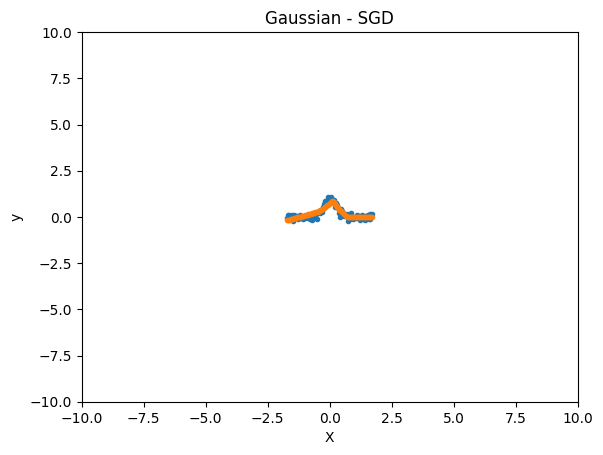

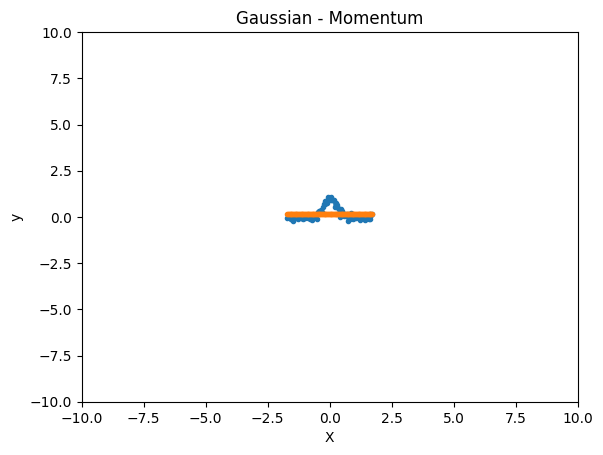

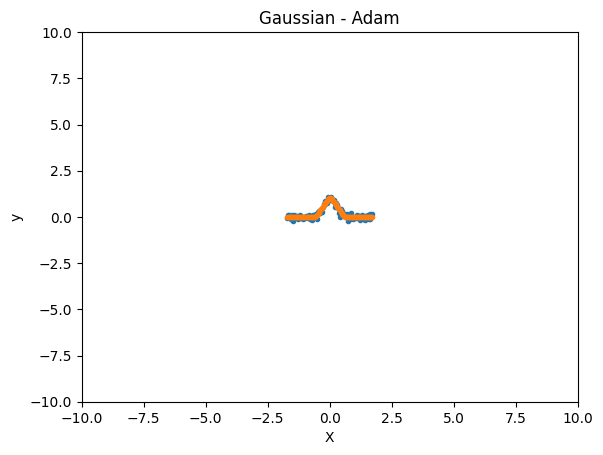


Visualizando resultados para Bimodal


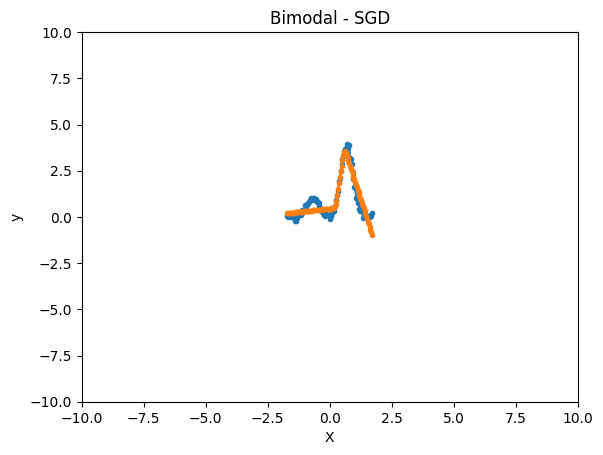

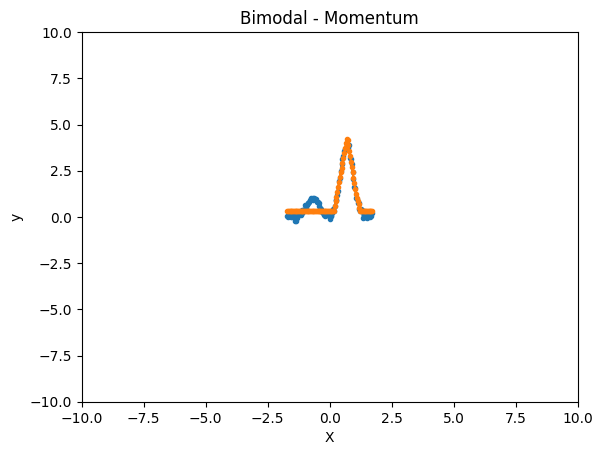

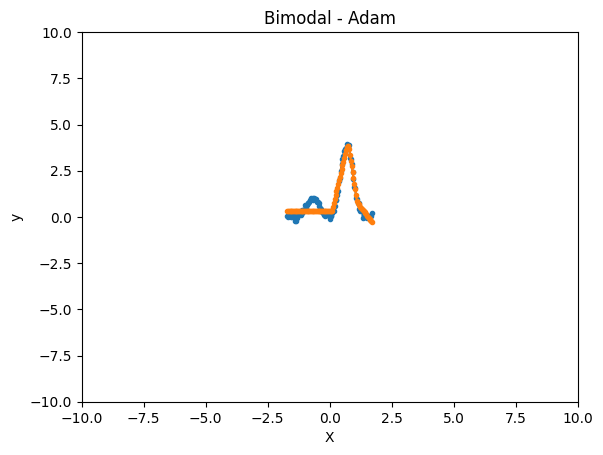


Visualizando resultados para Gabor


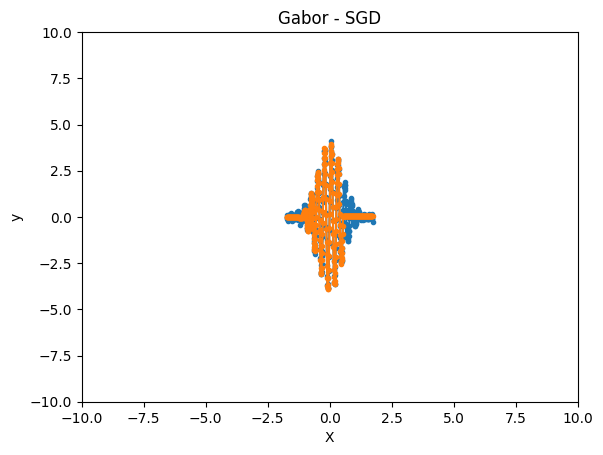

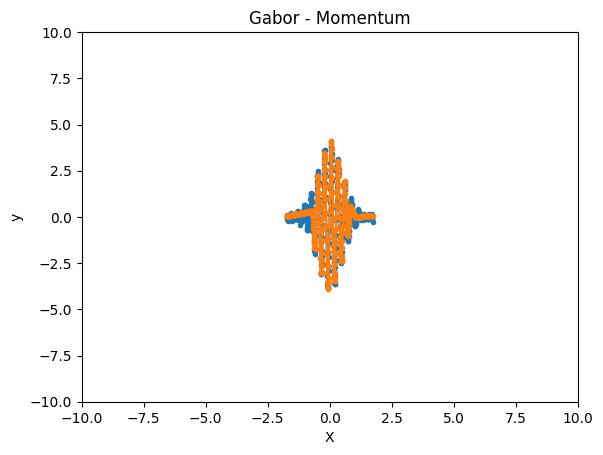

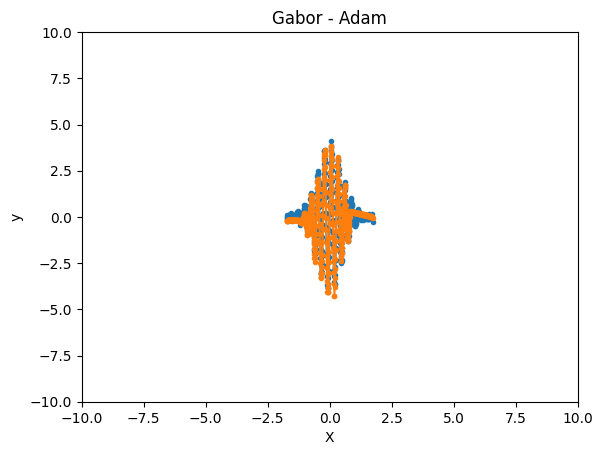


Visualizando resultados para Circle


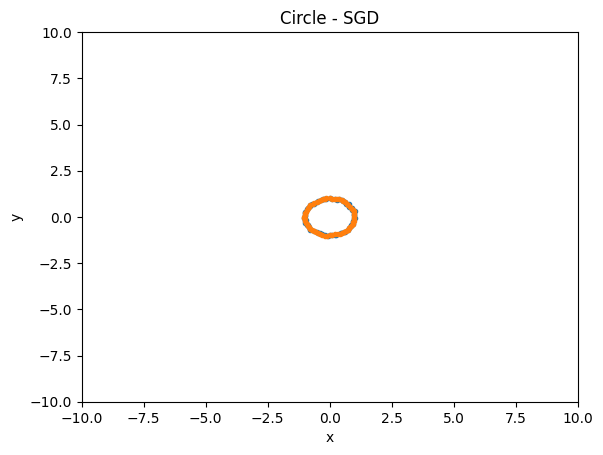

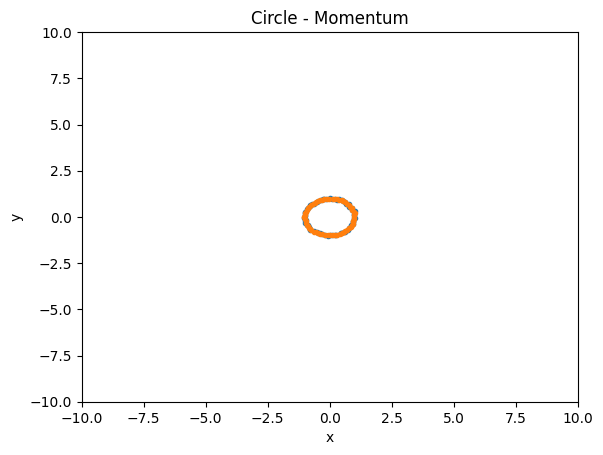

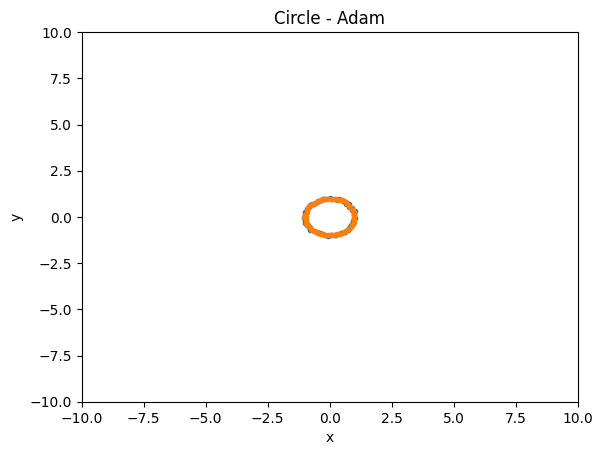

In [ ]:
# Visualização dos resultados
for dataset_name, results in datasets.items():
    print(f"\nVisualizando resultados para {dataset_name}")
    if dataset_name in ["Gaussian", "Bimodal", "Gabor"]:
        for method, metrics in results.items():
            net = metrics['network']
            X_test = datasets[dataset_name][method]['network'].config.X
            y_test = datasets[dataset_name][method]['network'].config.y
            pred = net.predictAll(X_test)
            DataDisplay.display_func_1D(
                [DataSet(X_test, y_test), DataSet(X_test, pred)],
                title=f"{dataset_name} - {method}"
            )
    elif dataset_name == "Circle":
        for method, metrics in results.items():
            net = metrics['network']
            X_test = datasets[dataset_name][method]['network'].config.X
            y_test = datasets[dataset_name][method]['network'].config.y
            pred = net.predictAll(X_test)
            DataDisplay.display_param_curv_2D(
                [DataSet(X_test, y_test), DataSet(X_test, pred)],
                title=f"{dataset_name} - {method}"
            )